In [32]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/')
db = client['cmdb_database']
collections = db.list_collection_names()
print(collections)

['IODurationsGw', 'IOSizes', 'IOSizesGw', 'SbbBbStatsGw', 'FileIOSummaryGw', 'SbbBbStats', 'ProcessSummaryGw', 'JobItemIopa', 'AdminStat', 'ProcessSummary', 'CmdFilterItem', 'FiolSroStats', 'IODurations', 'SystemSettings', 'FileIOSummary', 'JobItem', 'FiolSroStatsGw']


In [33]:
# getting all the jobs in db
import requests
api_uri="http://localhost"
api_token="3f9f66fbdb1f2982980521d1ca9ffb9aaf2af5c4"
url = f"{api_uri}/backend/api/job/search?apikey={api_token}"
print(url)
r = requests.get(url=url)
jobdata = r.json()['data']
joblist = []
for job in jobdata:
    joblist.append(job['id'])

print(joblist[0])


http://localhost/backend/api/job/search?apikey=3f9f66fbdb1f2982980521d1ca9ffb9aaf2af5c4
5acf6cce68db663d8a76b221


In [46]:
document = db[collections[-2]].find_one({'_id': ObjectId(joblist[0])})
print(len(bson.BSON.encode(document)))

1619


In [126]:
from bson.objectid import ObjectId

def get_job_duration(job_id):
     document = db['JobItem'].find_one({'_id': ObjectId(job_id)})
     return document['duration']

def get_job_id(job_id):
     document = db['JobItem'].find_one({'_id': ObjectId(job_id)})
     return document['jobid']

def get_job_size(job_id):
    id = get_job_id(job_id)
    for collection in collections:
        document = db[collection].find_one({'jobid': id})
        if document:
            size += len(bson.BSON.encode(document))
        else:
            size += 0
    return size


In [119]:
for collection in collections:
    document = db['JobItem'].find_one({'_id': ObjectId(joblist[1])})
    id = document['jobid']
    document = db[collection].find_one({'jobid': id})
    if document:
        print(f"job id found in {collection}")
    else:
        print(f"job id NOT found in {collection}")
    

job id found in IODurationsGw
job id found in IOSizes
job id found in IOSizesGw
job id NOT found in SbbBbStatsGw
job id found in FileIOSummaryGw
job id NOT found in SbbBbStats
job id found in ProcessSummaryGw
job id NOT found in JobItemIopa
job id NOT found in AdminStat
job id found in ProcessSummary
job id NOT found in CmdFilterItem
job id found in FiolSroStats
job id found in IODurations
job id NOT found in SystemSettings
job id found in FileIOSummary
job id found in JobItem
job id found in FiolSroStatsGw


In [123]:
#document = db['JobItem'].find_one({'_id': ObjectId(joblist[0])})
#pprint.pprint(document)
for collection in collections:
    size = db.command("collstats", collection)['size']
    storage_size = db.command("collstats", collection)['storageSize']
    print(f"{collection} : size = {size/1e6} | storage_size = {storage_size/1e6}")

IODurationsGw : size = 594.276727 | storage_size = 243.204096
IOSizes : size = 435.789986 | storage_size = 129.277952
IOSizesGw : size = 403.52036 | storage_size = 122.785792
SbbBbStatsGw : size = 0.0 | storage_size = 0.004096
FileIOSummaryGw : size = 1696.409915 | storage_size = 435.712
SbbBbStats : size = 0.0 | storage_size = 0.004096
ProcessSummaryGw : size = 362.672748 | storage_size = 109.469696
JobItemIopa : size = 0.009496 | storage_size = 0.016384
AdminStat : size = 0.065734 | storage_size = 0.086016
ProcessSummary : size = 400.398699 | storage_size = 115.24096
CmdFilterItem : size = 0.000187 | storage_size = 0.016384
FiolSroStats : size = 291.815245 | storage_size = 87.6544
IODurations : size = 626.711285 | storage_size = 251.580416
SystemSettings : size = 0.001299 | storage_size = 0.036864
FileIOSummary : size = 1715.202961 | storage_size = 420.933632
JobItem : size = 45.28753 | storage_size = 12.996608
FiolSroStatsGw : size = 285.236367 | storage_size = 86.6304


In [99]:
document = db[collections[-2]].find_one({'_id': ObjectId('5acf6cce68db663d8a76b221')})
print(document['duration'])
print(len(joblist))
#db.command("dbstats")
d = 0
for collection in collections:
    d += db.command("collstats", collection)['storageSize']
print(d)

1056.0
10011
2015649792


In [139]:
from bson.objectid import ObjectId

def get_job_duration(job_id):
     document = db['JobItem'].find_one({'_id': ObjectId(job_id)})
     return document['duration']

def get_job_id(job_id):
     document = db['JobItem'].find_one({'_id': ObjectId(job_id)})
     return document['jobid']

def get_job_size(job_id):
    size = 0
    id = get_job_id(job_id)
    for collection in collections:
        document = db[collection].find({'jobid': id})
        if document:
            for doc in document:                
                if doc:
                    size += len(bson.BSON.encode(doc))
                else:
                    size += 0
    return size

In [140]:
import pprint 
import bson
import pandas as pd
from bson.objectid import ObjectId
import time

df = pd.DataFrame(columns = ['duration', 'size'])

start = time.time()
total_size = 0
total_duration = 0
job_number = 0

for jobid in joblist:
    duration = get_job_duration(jobid)
    size = get_job_size(jobid)    
    df.loc[jobid] = [duration, size]    
    total_size += size
    total_duration += duration
    job_number += 1

    if job_number % 500==0:
        df.to_csv('data/db_size_jobs.csv')
        print(f"{job_number} jobs scanned for total size {total_size} and total duration of {total_duration}  - elapsed time is {time.time()-start}")


df.to_csv('data/db_size_jobs.csv')
print(f"{job_number} jobs scanned for total size {total_size} and total duration of {total_duration}  - elapsed time is {time.time()-start}")
df.head()

1000 jobs scanned for total size 1121891935 and total duration of 2532274.0  - elapsed time is 218.4830961227417
2000 jobs scanned for total size 1596675714 and total duration of 2736043.0  - elapsed time is 315.6173315048218
2001 jobs scanned for total size 1596718888 and total duration of 2736126.0  - elapsed time is 315.6506073474884


,duration,size
5acf6cce68db663d8a76b221,1056.0,425561.0
5acf6cce68db663d91483941,1061.0,453540.0
5acf70f068db663f9a628d81,996.0,406027.0
5acf710d68db663fc022d331,1001.0,480833.0
5acf74dd68db66412f4af951,997.0,403309.0


In [5]:
import pandas as pd
df = pd.read_csv('data/db_size_jobs.csv', index_col=0)
print(df.shape)
df.head()

(10011, 2)


,duration,size
5acf6cce68db663d8a76b221,1056.0,425561.0
5acf6cce68db663d91483941,1061.0,453540.0
5acf70f068db663f9a628d81,996.0,406027.0
5acf710d68db663fc022d331,1001.0,480833.0
5acf74dd68db66412f4af951,997.0,403309.0


In [10]:
df1 = df.sort_values(by=['duration'], inplace=False)
df1.head()

,duration,size
5e1cbda5928715c8ce969a72,20.0,13965.0
5e1cbb74928715c8ce9698d8,21.0,14172.0
5e1cb884928715c8ce9696af,22.0,12887.0
5e1be28b928715c8ce960b81,22.0,57777.0
5e1cc528928715c8ce96a01a,24.0,14163.0


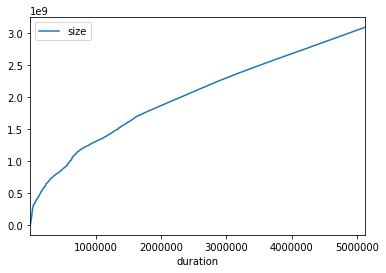

In [18]:
df2 = df1.cumsum(axis=0)
df2.head()
df2.plot(x='duration', y='size')

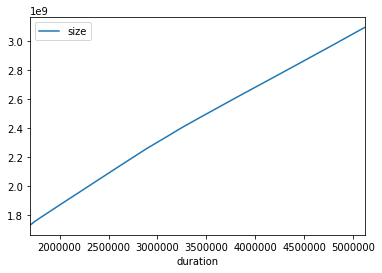

In [47]:
df3 = df2[df2.duration > 1.7e6]
df3.plot(x='duration', y='size')

In [51]:
# linear regression
import tensorflow as tf
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt 

x0 = df2['duration']/3600
y0 = df2['size']/1e6
x = df3['duration']/3600
y = df3['size']/1e6
# Define layer
layer0 = tf.keras.layers.Dense(units=1, input_shape=[1]) 
model = tf.keras.Sequential([layer0])
 
# Compile model
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(1))
 
# Train the model
history = model.fit(x, y, epochs=1000, verbose=False)
 
# Prediction
print('Prediction: {}'.format(model.predict([10])))
 
# Get weight and bias
weights = layer0.get_weights()
print('weight: {} bias: {}'.format(weights[0], weights[1]))
y_hat = weights[0][0][0]*x+weights[1][0]
print(f"r2 = {r2_score(y_hat, y)}")


Prediction: [[1079.4595]]
weight: [[1.4614216]] bias: [1064.8452]
r2 = 0.9978009028951677


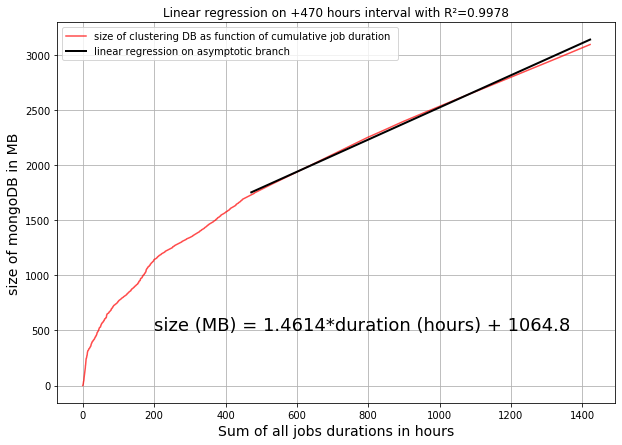

In [65]:
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(x0, y0, 'r', alpha = 0.7, label="size of clustering DB as function of cumulative job duration ")
plt.xlabel('Sum of all jobs durations in hours', fontsize=14)
plt.ylabel('size of mongoDB in MB', fontsize=14)
plt.plot(x, y_hat, 'k', lw = 2, label="linear regression on asymptotic branch ")
plt.grid()
plt.legend()
plt.title(f"Linear regression on +470 hours interval with R²={r2_score(y_hat, y):.4f}")
plt.text(200, 500, f"size (MB) = {weights[0][0][0]:.4f}*duration (hours) + {weights[1][0]:.1f}", fontsize=18)
plt.savefig('data/Linear_regression_on_size_of_clustering_DB.png')
plt.savefig('data/Linear_regression_on_size_of_clustering_DB.pdf')
#plt.show()


[-1030.50656317   373.33673696     2.28948955]


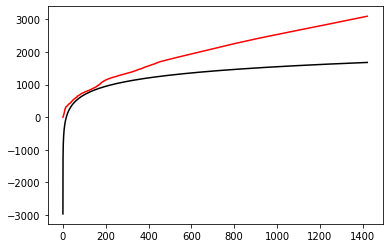

In [93]:
# curve fit
import scipy
import numpy as np
x0 = df2['duration'].values/3600
y0 = df2['size'].values/1e6
res = scipy.optimize.curve_fit(lambda x,a,b,c: a+b*np.log(x*c),  x0,  y0)
print(res[0])
y_fit = res[0][0] + res[0][1]*np.log(x0)
plt.plot(x0, y0, 'r')
plt.plot(x0, y_fit, 'k')

Prediction: [[1.1593746]]
weight: [[0.00145447]] bias: [1.1448299]
r2 = 0.9516857590845945


Text(200, 500, 'size (MB) = 0.0015*duration (hours) + 1.1')

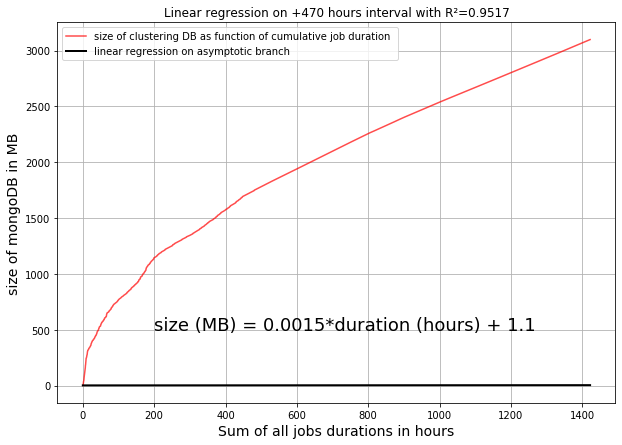

In [102]:
#plt.plot(x0, np.exp(y0/3000), 'r')
# linear regression
import tensorflow as tf
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt 


x = x0
y = np.exp(y0/3000)
# Define layer
layer0 = tf.keras.layers.Dense(units=1, input_shape=[1]) 
model = tf.keras.Sequential([layer0])
 
# Compile model
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(1))
 
# Train the model
history = model.fit(x, y, epochs=1000, verbose=False)
 
# Prediction
print('Prediction: {}'.format(model.predict([10])))
 


In [ ]:
# Get weight and bias
weights = layer0.get_weights()
print('weight: {} bias: {}'.format(weights[0], weights[1]))
y_hat = weights[0][0][0]*x+weights[1][0]
print(f"r2 = {r2_score(y_hat, y)}")
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(x, y, 'r', alpha = 0.7, label="size of clustering DB as function of cumulative job duration ")
plt.xlabel('Sum of all jobs durations in hours', fontsize=14)
plt.ylabel('size of mongoDB in MB', fontsize=14)
plt.plot(x, y_hat, 'k', lw = 2, label="linear regression on asymptotic branch ")
plt.grid()
plt.legend()
plt.title(f"Linear regression on +470 hours interval with R²={r2_score(y_hat, y):.4f}")
plt.text(200, 500, f"size (MB) = {weights[0][0][0]:.4f}*duration (hours) + {weights[1][0]:.1f}", fontsize=18)